# Building a Transformer Neural Network

Finally, let's build a new classifier, this time for the IMDB dataset, using a Transformer Neural Network.

In [1]:
import keras
import tensorflow as tf

vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
X_train = keras.utils.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.utils.pad_sequences(X_test, maxlen=maxlen)

In [2]:
X_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]])

In [3]:
X_test

array([[    0,     0,     0, ...,    14,     6,   717],
       [ 1987, 17975,    45, ...,   125,     4,  3077],
       [ 4468,   189,     4, ...,     9,    57,   975],
       ...,
       [    0,     0,     0, ...,    21,   846,  5518],
       [    0,     0,     0, ...,  2302,     7,   470],
       [    0,     0,     0, ...,    34,  2005,  2643]])

Using keras, implement a transformer block and a token and position embedding as layers, and use them to build a classifier. Train it for 1 epoch with Adam on the training partition while using the test partition to calculate the validation loss and accuracy at every epoch:

In [4]:
### YOUR CODE HERE ###

# Using keras, implement a transformer block and a token and position embedding as layers, and use them to build a classifier.
# Train it for 1 epoch with Adam on the training partition while using the test partition to calculate the validation loss and accuracy at every epoch

from keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout
from keras.models import Model
from keras.layers import MultiHeadAttention
from keras.layers import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers import Add
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling1D
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Reshape
from keras.layers import Lambda
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import BatchNormalization

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [5]:
# Define the model
embed_dim = 128
num_heads = 4
num_transformer_blocks = 4
ff_dim = 128
inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
for _ in range(num_transformer_blocks):
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=x)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 167ms/step - accuracy: 0.5004 - loss: 0.7045 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 182ms/step - accuracy: 0.5030 - loss: 0.6932 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - accuracy: 0.5044 - loss: 0.6933 - val_accuracy: 0.4938 - val_loss: 0.6932
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.4927 - loss: 0.6932
Test Loss: 0.6931548714637756
Test Accuracy: 0.5


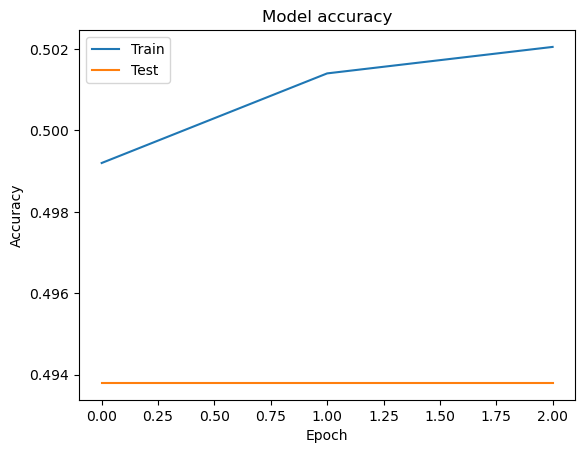

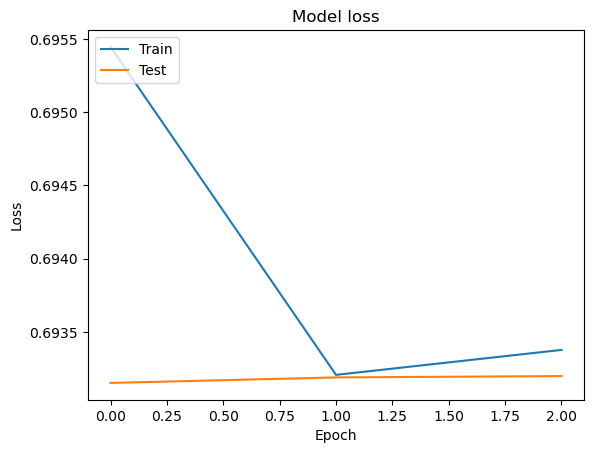

In [6]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.2)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 200, 128)       │     2,585,600 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 128)       │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 128)       │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 200, 128)       │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 200, 128)       │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,332,733 (43.23 MB)

 Trainable params: 3,777,577 (14.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,555,156 (28.82 MB)

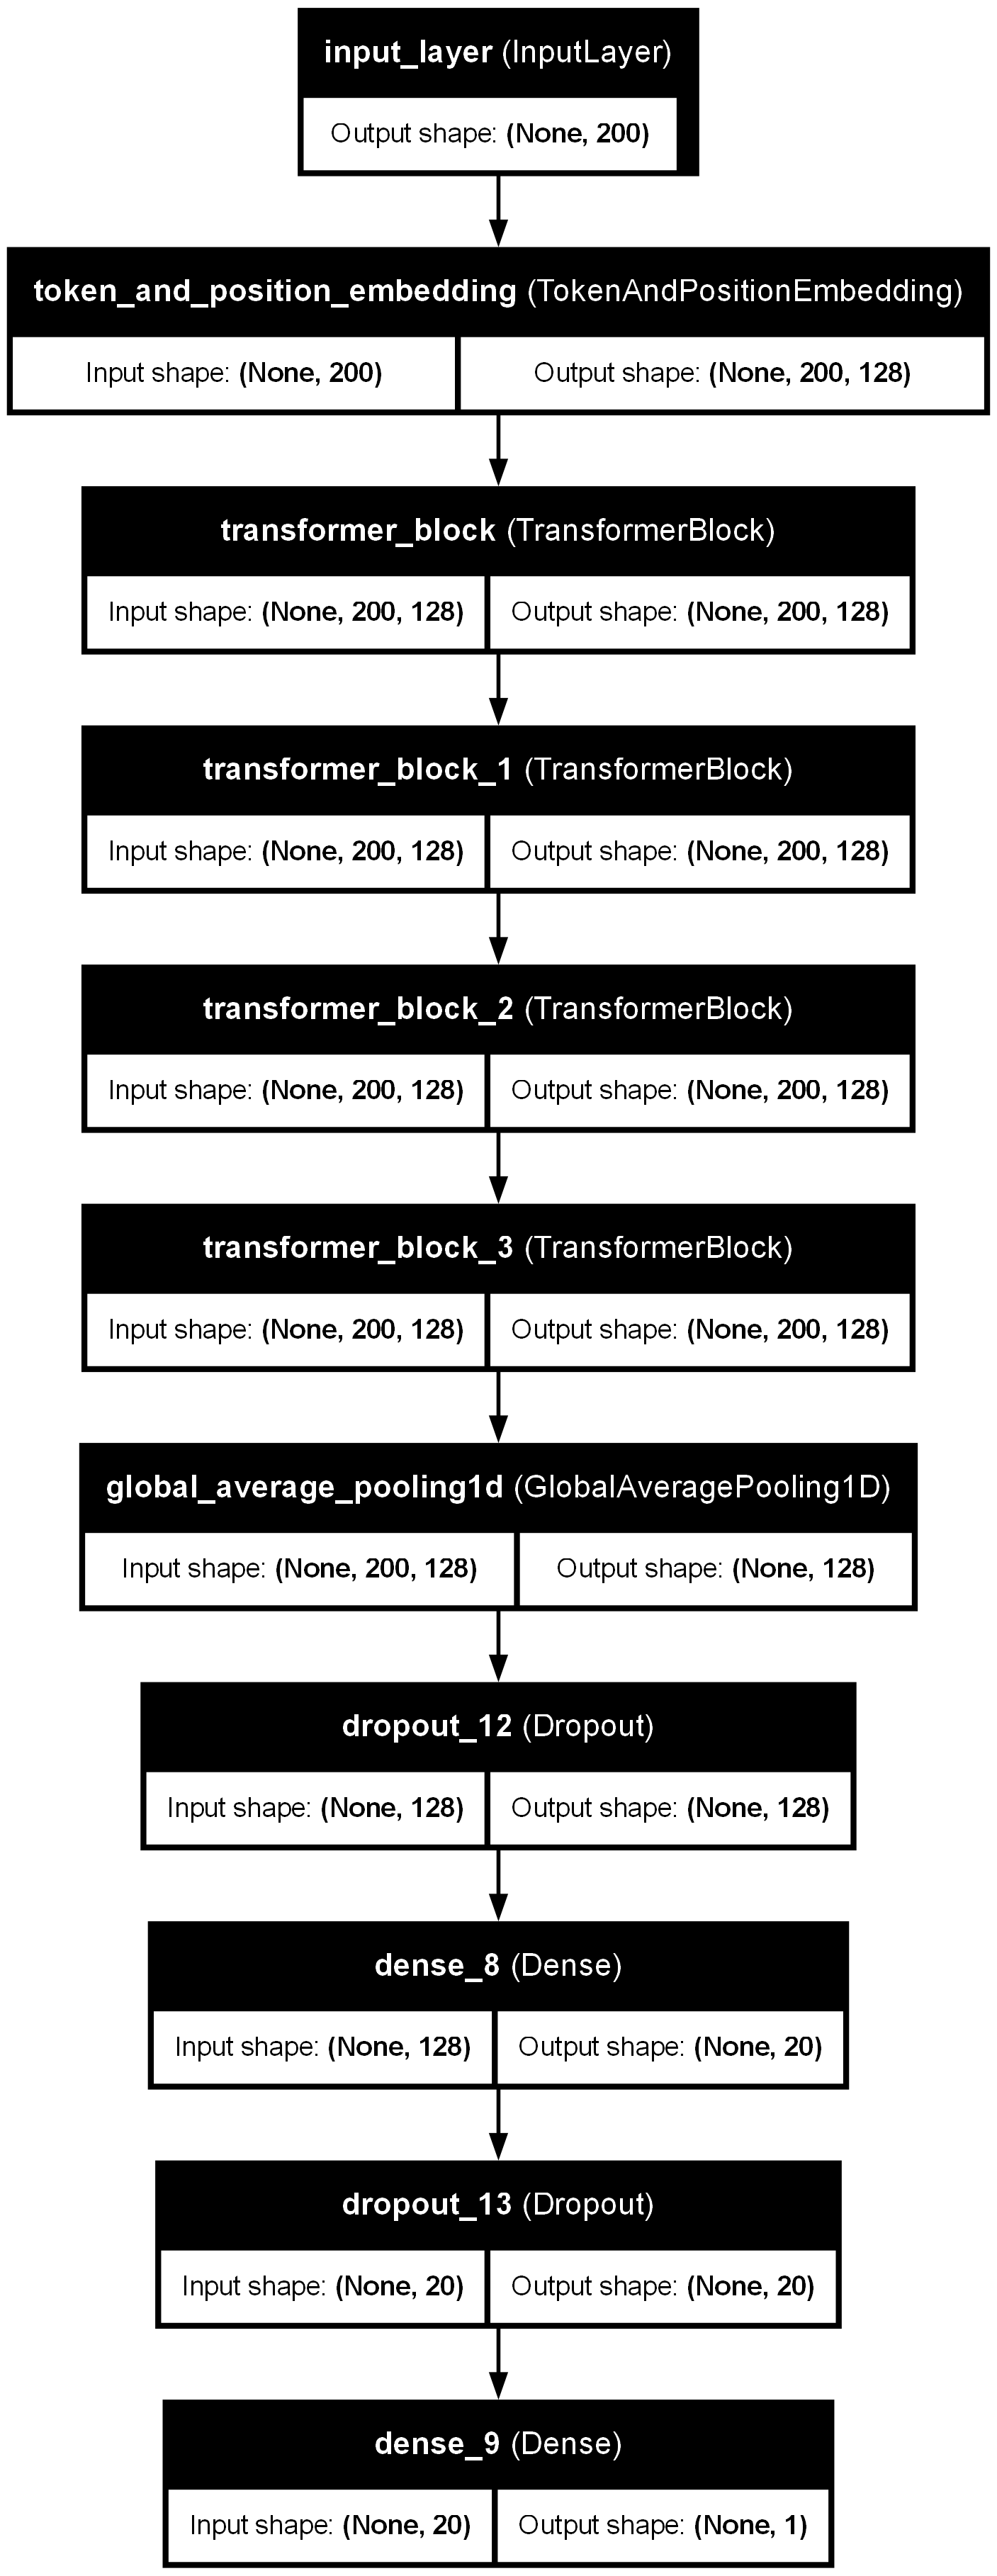

In [7]:

# Print the model summary
model.summary()

# Print the model architecture
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### ^^^^^^^^^